In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.1.0


In [4]:
import logging
np.set_printoptions(suppress=True)
logging.basicConfig(level="ERROR")

In [5]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [6]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


In [7]:
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

In [8]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:20]),
 NamedSplit('train')(tfds.percent[20:21]),
 NamedSplit('train')(tfds.percent[21:100]))

In [9]:
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>
<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>


In [10]:
for en, zh in train_examples.take(3):
    print(en)
    print(zh)
    print('-' * 10)

tf.Tensor(b'Making Do With More', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97', shape=(), dtype=string)
----------
tf.Tensor(b'If the Putins, Erdo\xc4\x9fans, and Orb\xc3\xa1ns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa6\x82\xe6\x9e\x9c\xe6\x99\xae\xe4\xba\xac\xe3\x80\x81\xe5\x9f\x83\xe5\xb0\x94\xe5\xa4\x9a\xe5\xae\x89\xe5\x92\x8c\xe6\xac\xa7\xe5\xb0\x94\xe7\x8f\xad\xe5\xb8\x8c\xe6\x9c\x9b\xe7\xbb\xa7\xe7\xbb\xad\xe4\xba\xab\xe6\x9c\x89\xe5\xbc\x80\xe6\x94\xbe\xe5\x9b\xbd\xe9\x99\x85\xe4\xbd\x93\xe7\xb3\xbb\xe6\x8f\x90\xe4\xbe\x9b\xe7\x9a\x84\xe7\xbb\x8f\xe6\xb5\x8e\xe5\x88\xa9\xe7\x9b\x8a\xef\xbc\x8c\xe5\xb0\xb1\xe4\xb8\x8d\xe8\x83\xbd\xe7\xae\x80\xe5\x8d\x95\xe5\x9c\xb0\xe5\x88\xb6\xe5\xae\x9a\xe8\x87\xaa\xe5\xb7\xb1\xe7\x9a\x84\xe8\xa7\x84\xe5\x88\x99\xe3\x80\x82', shape=(), dtype=string)
-------

In [11]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print(en)
  print(zh)
  print('-' * 10)
  
  # 之後用來簡單評估模型的訓練情況
  sample_examples.append((en, zh))

Making Do With More
多劳应多得
----------
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。
----------
This ceiling can be raised only in a deep depression or other exceptional circumstances, allowing for counter-cyclical policy so long as it is agreed that the additional deficit is cyclical, rather than structural.
只有在发生深度萧条或其他反常事件时，这一上限才能做出调整，以便让反周期政策实施足够的长度，使人们一致认为增加的赤字是周期性的，而不是结构性的。
----------
Fascist and communist regimes of the past, which followed a similar instrumentalist approach to democracy, come to mind here.
在此我们想起了过去的法西斯主义和共产主义。 它们都相似地将民主作为实现其目的的工具。
----------
This phase culminated with the collapse of communism in 1989, but the chance to overcome the Continent’s historical divisions now required a redefinition of the European project.
这种状态随着1989年共产主义崩溃而达至巅峰，但是克服欧洲大陆历史性分裂的机遇现在需要重新定义欧洲计划。
----------
The eurozone’

In [12]:
%%time
try:
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 有需要可以調整字典大小
  
  # 將字典檔案存下以方便下次 warmstart
  subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：8135
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']

CPU times: user 1min 30s, sys: 12.3 s, total: 1min 42s
Wall time: 1min 4s


In [13]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[2700, 7911, 10, 2942, 7457, 1163, 7925]

In [14]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 2700     Taiwan
 7911      
   10     is 
 2942     bea
 7457     uti
 1163     ful
 7925     .


In [15]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Taiwan is beautiful.', 'Taiwan is beautiful.')


In [16]:
%%time
try:
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) # 每一個中文字就是字典裡的一個單位
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：4201
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 7min 46s, sys: 11.6 s, total: 7min 58s
Wall time: 7min 22s


In [17]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

多劳应多得
[48, 557, 116, 48, 81]


In [22]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[17, 965, 11, 6, 1707, 676, 8, 211, 2712, 6683, 249, 3, 85, 1447, 7925]
[45, 206, 171, 1, 847, 197, 236, 604, 45, 90, 17, 130, 102, 36, 7, 284, 80, 18, 212, 265, 3]


In [31]:
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

In [32]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8135
英文 EOS 的 index： 8136
中文 BOS 的 index： 4201
中文 EOS 的 index： 4202

輸入為 2 個 Tensors：
(<tf.Tensor: shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)
---------------
輸出為 2 個索引序列：
([8135, 4682, 19, 717, 7911, 298, 2701, 7980, 8136],
 [4201, 48, 557, 116, 48, 81, 4202])


In [33]:
train_dataset = train_examples.map(encode)

AttributeError: in converted code:

    <ipython-input-23-c5074703b8a5>:5 encode  *
        en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [25]:
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
  # 要到 `tf.py_funtion` 裡頭才是
  # 另外因為索引都是整數，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor([8135 4682   19  717 7911  298 2701 7980 8136], shape=(9,), dtype=int64)
tf.Tensor([4201   48  557  116   48   81 4202], shape=(7,), dtype=int64)


In [28]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [34]:
# 因為我們數據量小可以這樣 count
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

所有英文與中文序列長度都不超過 40 個 tokens
訓練資料集裡總共有 29914 筆數據


In [36]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 4682   19 ...    0    0    0]
 [8135   17  965 ... 8136    0    0]
 [8135 6602    2 ...    0    0    0]
 ...
 [8135 1097  270 ...    0    0    0]
 [8135 1713   70 ...    0    0    0]
 [8135 2731 4553 ...    0    0    0]], shape=(64, 34), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   48  557 ...    0    0    0]
 [4201   45  206 ...    0    0    0]
 [4201   58    5 ...  683    3 4202]
 ...
 [4201   29  120 ...    0    0    0]
 [4201  297  161 ...    0    0    0]
 [4201  279  149 ... 4202    0    0]], shape=(64, 40), dtype=int64)


In [37]:
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [38]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135  264  559 ...    0    0    0]
 [8135   39   41 ...    0    0    0]
 [8135   45  409 ...    0    0    0]
 ...
 [8135   45  346 ...    0    0    0]
 [8135   17 1410 ...    0    0    0]
 [8135   89   10 ...    0    0    0]], shape=(128, 40), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201  127   20 ...    0    0    0]
 [4201   35    6 ...    0    0    0]
 [4201  120  340 ...    0    0    0]
 ...
 [4201   15   14 ...    0    0    0]
 [4201   45   90 ...    0    0    0]
 [4201  240   54 ...    3 4202    0]], shape=(128, 40), dtype=int64)


In [41]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [42]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)


In [43]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.00872516,  0.03628476, -0.03393974,  0.00709321],
         [-0.03939278, -0.0301337 , -0.00684045,  0.03930915],
         [ 0.04217876,  0.03556073,  0.00940926,  0.02619899],
         [ 0.00395658, -0.02045913,  0.04225378,  0.03054985],
         [-0.0017071 , -0.01169461, -0.03898996,  0.02977444],
         [-0.01053456, -0.02597178,  0.0221846 , -0.03926188],
         [ 0.00246267, -0.0197565 ,  0.03870387,  0.04282421],
         [ 0.00246267, -0.0197565 ,  0.03870387,  0.04282421]],
 
        [[-0.00872516,  0.03628476, -0.03393974,  0.00709321],
         [-0.02387941,  0.03241142, -0.02551947, -0.04527463],
         [-0.01562656,  0.01015867, -0.00413325, -0.02324653],
         [-0.03823967, -0.01697657, -0.03591858,  0.03328835],
         [-0.03155795,  0.00274887,  0.04581268,  0.04479903],
         [ 0.00292424, -0.04440271, -0.01196776,  0.04736396],
         [-0.0017071 , -0.01169461, -0.03898996,  0.02977444],


In [44]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[-0.00556985 -0.04969132 -0.04252383 -0.02408794]
 [-0.00556985 -0.04969132 -0.04252383 -0.02408794]
 [-0.00556985 -0.04969132 -0.04252383 -0.02408794]], shape=(3, 4), dtype=float32)


In [45]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [46]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [47]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [48]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [49]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37518066 0.37483087 0.3749091  0.4999044 ]
  [0.37498498 0.3751402  0.3751197  0.4999625 ]
  [0.37501425 0.37473822 0.37502044 0.49995366]
  [0.37481582 0.37508464 0.3751502  0.50004935]
  [0.37512243 0.37493312 0.37505168 0.49990326]
  [0.37488103 0.3752157  0.37497765 0.5001095 ]
  [0.37483    0.37506163 0.37517226 0.500027  ]
  [0.37483    0.37506163 0.37517226 0.500027  ]]

 [[0.62518704 0.24983297 0.6250395  0.3749666 ]
  [0.6252012  0.24961075 0.62512374 0.37471482]
  [0.6250589  0.24984503 0.6250475  0.3748681 ]
  [0.62508297 0.250073   0.6250168  0.37506855]
  [0.62479925 0.25036332 0.6248135  0.37528878]
  [0.62492156 0.25029588 0.6249556  0.37520885]
  [0.625098   0.2500403  0.62503004 0.3750695 ]
  [0.6249098  0.24994117 0.62504107 0.37484056]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12518652 0.12500928 0.12507352 0.1248996  0.12509455 0.12490661
   0.12491497 0.12491497]
  [0.12491778 0.12518606 0.124

In [50]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [51]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[0.16687751 0.16664125 0.16672687 0.16649503 0.1667549  0.16650438
   0.         0.        ]
  [0.16658036 0.16693811 0.16645308 0.16671462 0.16675499 0.16655882
   0.         0.        ]
  [0.16671546 0.16650249 0.1669682  0.16670282 0.16664349 0.16646752
   0.         0.        ]
  [0.16646041 0.16674086 0.16667958 0.16688935 0.16658437 0.16664544
   0.         0.        ]
  [0.16671544 0.16677645 0.16661547 0.16657959 0.16683397 0.1664791
   0.         0.        ]
  [0.16655472 0.16667004 0.16652924 0.16673048 0.16656885 0.16694666
   0.         0.        ]
  [0.16646451 0.16676985 0.16668403 0.16689003 0.16660948 0.16658214
   0.         0.        ]
  [0.16646451 0.16676985 0.16668403 0.16689003 0.16660948 0.16658214
   0.         0.        ]]

 [[0.1251336  0.12509197 0.12500137 0.12504466 0.1249175  0.12491547
   0.12504166 0.12485382]
  [0.12510405 0.1252538  0.12509975 0.12496921 0.12483636 0.12477439
   0.12494024 0.12502226]
  [0.12502307 0.125

In [52]:
# 事實上也不完全是上句話的翻譯，
# 因為我們在第一個維度還是把兩個句子都拿出來方便你比較
attention_weights[:, :, -2:]

<tf.Tensor: shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.12504166, 0.12485382],
        [0.12494024, 0.12502226],
        [0.12495412, 0.12503818],
        [0.12508827, 0.12484362],
        [0.12495244, 0.12494925],
        [0.12511837, 0.12490624],
        [0.12511808, 0.12485193],
        [0.12490998, 0.12519331]]], dtype=float32)>

In [53]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[-0.03401262 -0.03672125  0.00148769 -0.02200452]
  [-0.00802097 -0.04834964 -0.02985298 -0.02165037]
  [-0.04805389  0.03293635 -0.03475545 -0.01825899]
  [-0.01045249  0.03329812  0.01279325 -0.03139227]
  [-0.00984706 -0.02574105 -0.01065782  0.01140115]
  [ 0.04679844  0.01800437  0.00799765  0.04974586]
  [ 0.00132418 -0.03924266 -0.00341817 -0.03768504]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]]

 [[-0.03401262 -0.03672125  0.00148769 -0.02200452]
  [ 0.00608138  0.03791398 -0.00718598  0.00104474]
  [-0.01411204  0.02962438  0.01688961  0.02466543]
  [ 0.03541957  0.00966803  0.0428454   0.03259467]
  [ 0.02886103  0.03402147 -0.00361333 -0.03875045]
  [ 0.00446288 -0.02858969  0.0252871   0.01449865]
  [-0.03010942 -0.03628191 -0.03144275 -0.04487304]
  [ 0.00266431 -0.03812676  0.02856315  0.04966343]
  [ 0.04679844  0.01800437  0.00799765  0.

In [54]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.4998398  0.5001602  0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.33313262 0.33304116 0.3338263  0.         0.         0.
   0.         0.         0.         0.        ]
  [0.24989563 0.24976186 0.25013125 0.25021127 0.         0.
   0.         0.         0.         0.        ]
  [0.20006233 0.2001005  0.19993976 0.19983621 0.2000613  0.
   0.         0.         0.         0.        ]
  [0.16646475 0.16652916 0.16650583 0.16663018 0.16670573 0.1671644
   0.         0.         0.         0.        ]
  [0.14296137 0.14300315 0.14276354 0.14278981 0.14284588 0.14262104
   0.14301524 0.         0.         0.        ]
  [0.12505664 0.12516657 0.12493589 0.1248152  0.1249961  0.1247335
   0.12508884 0.12520729 0.         0.        ]
  [0.11114098 0.11123868 0.11103366 0.1109264  0.11108718 0.1108538
   0.111

In [55]:
attention_weights[:, 0, :]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [56]:
attention_weights[:, 1, :]


<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.4998398, 0.5001602, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.499605 , 0.500395 , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)>

In [59]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[-0.00872516  0.03628476 -0.03393974  0.00709321]
  [-0.03939278 -0.0301337  -0.00684045  0.03930915]
  [ 0.04217876  0.03556073  0.00940926  0.02619899]
  [ 0.00395658 -0.02045913  0.04225378  0.03054985]
  [-0.0017071  -0.01169461 -0.03898996  0.02977444]
  [-0.01053456 -0.02597178  0.0221846  -0.03926188]
  [ 0.00246267 -0.0197565   0.03870387  0.04282421]
  [ 0.00246267 -0.0197565   0.03870387  0.04282421]]

 [[-0.00872516  0.03628476 -0.03393974  0.00709321]
  [-0.02387941  0.03241142 -0.02551947 -0.04527463]
  [-0.01562656  0.01015867 -0.00413325 -0.02324653]
  [-0.03823967 -0.01697657 -0.03591858  0.03328835]
  [-0.03155795  0.00274887  0.04581268  0.04479903]
  [ 0.00292424 -0.04440271 -0.01196776  0.04736396]
  [-0.0017071  -0.01169461 -0.03898996  0.02977444]
  [-0.01053456 -0.02597178  0.0221846  -0.03926188]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[-0.00872516  0.03628476]
   [-0.03939278 -0.0301337 ]
   [ 0.04217876  0.03556073]
   [ 0.0039

In [60]:
# 實作一個執行多頭注意力機制的 keras layer
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  # 這跟我們前面看過的函式有 87% 相似
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
    # 輸出會多一個 head 維度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [61]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[-0.01000656  0.0136093   0.01146611 -0.0000503 ]
  [-0.00998217  0.01357744  0.01145472 -0.00002868]
  [-0.00996785  0.01356275  0.0114211  -0.00005009]
  [-0.00995941  0.01354941  0.01142498 -0.00002872]
  [-0.00998485  0.01357907  0.01144329 -0.00004433]
  [-0.00999995  0.01359164  0.01145778 -0.00003175]
  [-0.00995556  0.01354592  0.01142278 -0.00002877]
  [-0.00995556  0.01354592  0.01142278 -0.00002877]]

 [[ 0.00610415 -0.01002899 -0.01386858  0.00167259]
  [ 0.00606181 -0.00998417 -0.01382717  0.00168069]
  [ 0.00609498 -0.01002481 -0.01385703  0.00168881]
  [ 0.00613258 -0.01006723 -0.01388553  0.00169558]
  [ 0.00615591 -0.01009651 -0.01390056  0.00171272]
  [ 0.00617421 -0.01011746 -0.01393264  0.00169231]
  [ 0.00614059 -0.01007446 -0.01390366  0.00167899]
  [ 0.00610405 -0.010

In [62]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [63]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [64]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ]],
      dtype=float32)>

In [66]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [67]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[-0.00872516  0.03628476 -0.03393974  0.00709321]
  [-0.03939278 -0.0301337  -0.00684045  0.03930915]
  [ 0.04217876  0.03556073  0.00940926  0.02619899]
  [ 0.00395658 -0.02045913  0.04225378  0.03054985]
  [-0.0017071  -0.01169461 -0.03898996  0.02977444]
  [-0.01053456 -0.02597178  0.0221846  -0.03926188]
  [ 0.00246267 -0.0197565   0.03870387  0.04282421]
  [ 0.00246267 -0.0197565   0.03870387  0.04282421]]

 [[-0.00872516  0.03628476 -0.03393974  0.00709321]
  [-0.02387941  0.03241142 -0.02551947 -0.04527463]
  [-0.01562656  0.01015867 -0.00413325 -0.02324653]
  [-0.03823967 -0.01697657 -0.03591858  0.03328835]
  [-0.03155795  0.00274887  0.04581268  0.04479903]
  [

In [68]:
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

In [69]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [70]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[-0.03401262 -0.03672125  0.00148769 -0.02200452]
  [-0.00802097 -0.04834964 -0.02985298 -0.02165037]
  [-0.04805389  0.03293635 -0.03475545 -0.01825899]
  [-0.01045249  0.03329812  0.01279325 -0.03139227]
  [-0.00984706 -0.02574105 -0.01065782  0.01140115]
  [ 0.04679844  0.01800437  0.00799765  0.04974586]
  [ 0.00132418 -0.03924266 -0.00341817 -0.03768504]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]
  [-0.00556985 -0.04969132 -0.04252383 -0.02408794]]

 [[-0.03401262 -0.03672125  0.00148769 -0.02200452]
  [ 0.00608138  0.03791398 -0.00718598  0.00104474]
  [-0.01411204  0.02962438  0.01688961  0.02466543]
  [ 0.03541957  0.00966803  0.0428454   0.03259467]
  [ 0.02886103  0.03402147 -0.00361333 -0.03875045]
  [ 0.00446288 -0.02858969  0.0252871   0.01449865]
  [-0.03010942 -0.03628191 -0.03144275 -0.04487304]
  [ 0.00266431 -0.03812676  0.02856315  0.04966343]
  [ 0.04679844  0.01800437  0.00799765  0.

In [71]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

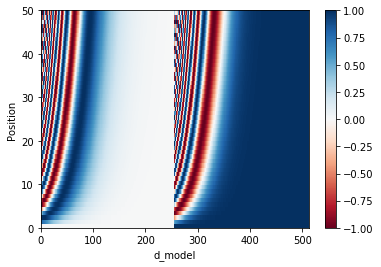

In [72]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [73]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 

In [74]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 -0.5846039  -0.3143984   1.7055432 ]
  [-0.46891177 -0.5740812  -0.68403816  1.7270309 ]
  [-0.3197091  -0.17782497 -1.1191479   1.6166819 ]
  [-0.49274147  0.2699072  -1.2412686   1.464103  ]
  [-0.88477206  0.16279443 -0.8493917   1.5713693 ]
  [-0.9662535  -0.25279236 -0.45335218  1.6723982 ]
  [-0.84764326 -0.5615214  -0.2887244   1.6978891 ]
  [-0.61957765 -0.59192634 -0.51938546  1.7308894 ]]

 [[-0.80838835 -0.56457365 -0.33460823  1.7075703 ]
  [-0.50152004 -0.5214133  -0.7037289   1.7266624 ]
  [-0.34244877 -0.11313806 -1.144456    1.6000429 ]
  [-0.50724393  0.21401617 -1.205033    1.4982607 ]
  [-0.8861126   0.26368496 -0.9036027   1.5260304 ]
  [-0.96629447 -0.21083693 -0.49055362  1.667685  ]
  [-0.8683281  -0.53832126 -0.28836071  1.6950102 ]
  [-0.6246324  -0.5758679  -0.5305908   1.7310

In [75]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [76]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 

In [77]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [78]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0]
 [4201  162  467  421  189   14    7  553    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   80   27    3 4202    0    0    0]
 [ 162  467  421  189   14    7  553    3 4202]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576237]
  [ 0.03640017 -0.0188504   0.0511385  ... -0.02349907  0.01716621
   -0.06729947]
  [ 0.05617092 -0.02265773  0.04667147 ... -0.02913138  0.02415059
   -0.05331098]
  ...
  [ 0.00905135 -0.01058669  0.05486143 ... -0.01039154  0.0058039
   -0.07445521]
  [ 0.02215609 -0.01478041  0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.04786561 -0.02148081  0.04837158 ... -0.0275

In [79]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

In [80]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))


predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576237]
  [ 0.03640017 -0.0188504   0.0511385  ... -0.02349907  0.01716621
   -0.06729947]
  [ 0.05617092 -0.02265773  0.04667147 ... -0.02913138  0.02415059
   -0.05331098]
  ...
  [ 0.00905135 -0.01058669  0.05486143 ... -0.01039154  0.0058039
   -0.07445521]
  [ 0.02215609 -0.01478041  0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.04786561 -0.02148081  0.04837158 ... -0.02759764  0.02148173
   -0.06043392]]

 [[ 0.00996658 -0.01115559  0.05453675 ... -0.0114185   0.00637142
   -0.07500791]
  [ 0.03897631 -0.01930442  0.0508956  ... -0.02409907  0.01803425
   -0.06564321]
  [ 0.05387273 -0.02244362  0.04702405 ... -0.02893806  0.02348556
   -0.05554678]
  ...
  [ 0.01048943 -0.01085558  0.05502524 ... -0.01070841  0.0062833
   -0.0738526 ]
  [ 0.02370837 -0.01504853  0.05381611 ... -0.01732858  0.01186723
   -0.07158873]
  [ 0.04920106 -0.02166032  0.0481827  ... -0.02781

In [81]:
def loss_function(real, pred):
  # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
  return tf.reduce_mean(loss_)

In [82]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [83]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8137
target_vocab_size: 4203


In [84]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

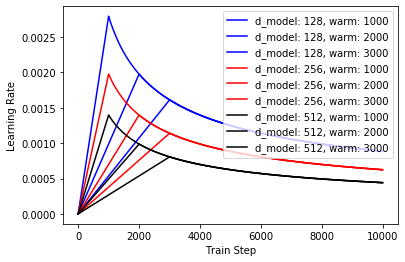

In [85]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [86]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8137
target_vocab_size: 4203
dropout_rate: 0.1




In [87]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


In [88]:
# 為 Transformer 的 Encoder / Decoder 準備遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [89]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [90]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置紀錄 TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  

  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將 loss 以及 accuracy 寫到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30


Saving checkpoint for epoch 1 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-1
Epoch 1 Loss 5.1926 Accuracy 0.0195
Time taken for 1 epoch: 288.58325695991516 secs

Saving checkpoint for epoch 2 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-2
Epoch 2 Loss 4.2485 Accuracy 0.0599
Time taken for 1 epoch: 250.06949520111084 secs

Saving checkpoint for epoch 3 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-3
Epoch 3 Loss 3.7378 Accuracy 0.0998
Time taken for 1 epoch: 230.621248960495 secs

Saving checkpoint for epoch 4 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-4
Epoch 4 Loss 3.2605 Accuracy 0.1534
Time taken for 1 epoch: 236.94213795661926 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-5
Epoch 5 Loss 2.9613 Accuracy 0.1826
Time taken for 1 epoch: 233.04599022865295 secs

Saving checkpoint for epoch 6 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-6
E

KeyboardInterrupt: 